In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import VGG19
from ipykernel import kernelapp as app

2021-10-26 06:50:19.691061: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-26 06:50:19.691174: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
flower_data = get_data("../input/flower-dataset/flowers")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

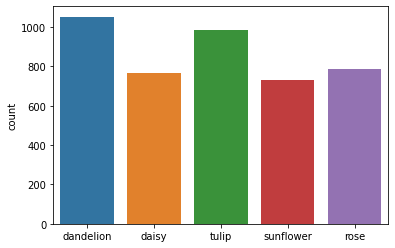

In [6]:
l = []
for i in flower_data:
    l.append(labels[i[1]])
sns.set_style()
sns.countplot(l)

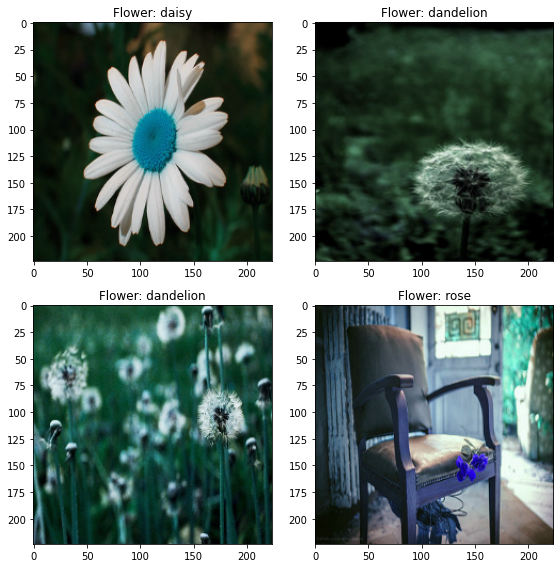

In [7]:
fig,ax=plt.subplots(2,2)
fig.set_size_inches(8,8)
for i in range(2):
    for j in range (2):
        l=random.randint(0,len(flower_data))
        ax[i,j].imshow(flower_data[l][0])
        ax[i,j].set_title('Flower: '+labels[flower_data[l][1]])
        
plt.tight_layout()

In [8]:
x = []
y = []

for feature, label in flower_data:
    x.append(feature)
    y.append(label)

In [9]:
x = np.array(x) / 255
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [10]:
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

In [12]:
del x,y,flower_data

In [13]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-10-26 06:52:21.068064: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-26 06:52:21.070876: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-26 06:52:21.070966: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-26 06:52:21.071009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1d173b4c34ca): /proc/driver/nvidia/version does not exist
2021-10-26 06:52:21.073514: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [14]:
pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:19]:
  layer.trainable = False

model = Sequential([
      pre_trained_model,
      MaxPool2D((2,2) , strides = 2),
      Flatten(),
      Dense(5 , activation='softmax')])

model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [15]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 15 , validation_data = (x_test, y_test))

2021-10-26 06:52:53.138068: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2079092736 exceeds 10% of free system memory.


Epoch 1/15
54/54 [==============================] - 74s 1s/step - loss: 1.4024 - accuracy: 0.5358 - val_loss: 0.5564 - val_accuracy: 0.8206
Epoch 2/15
54/54 [==============================] - 71s 1s/step - loss: 0.3971 - accuracy: 0.8581 - val_loss: 0.4118 - val_accuracy: 0.8576
Epoch 3/15
54/54 [==============================] - 70s 1s/step - loss: 0.2346 - accuracy: 0.9163 - val_loss: 0.4597 - val_accuracy: 0.8576
Epoch 4/15
54/54 [==============================] - 71s 1s/step - loss: 0.1322 - accuracy: 0.9632 - val_loss: 0.4622 - val_accuracy: 0.8634
Epoch 5/15
54/54 [==============================] - 71s 1s/step - loss: 0.0850 - accuracy: 0.9757 - val_loss: 0.4666 - val_accuracy: 0.8681
Epoch 6/15
54/54 [==============================] - 71s 1s/step - loss: 0.0558 - accuracy: 0.9833 - val_loss: 0.6564 - val_accuracy: 0.8519
Epoch 7/15
54/54 [==============================] - 71s 1s/step - loss: 0.0382 - accuracy: 0.9894 - val_loss: 0.5101 - val_accuracy: 0.8623
Epoch 8/15
54/54 [==

In [16]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

27/27 [==============================] - 13s 439ms/step - loss: 0.6720 - accuracy: 0.8403
Loss of the model is -  0.6719714403152466
27/27 [==============================] - 13s 439ms/step - loss: 0.6720 - accuracy: 0.8403
Accuracy of the model is -  84.02777910232544 %


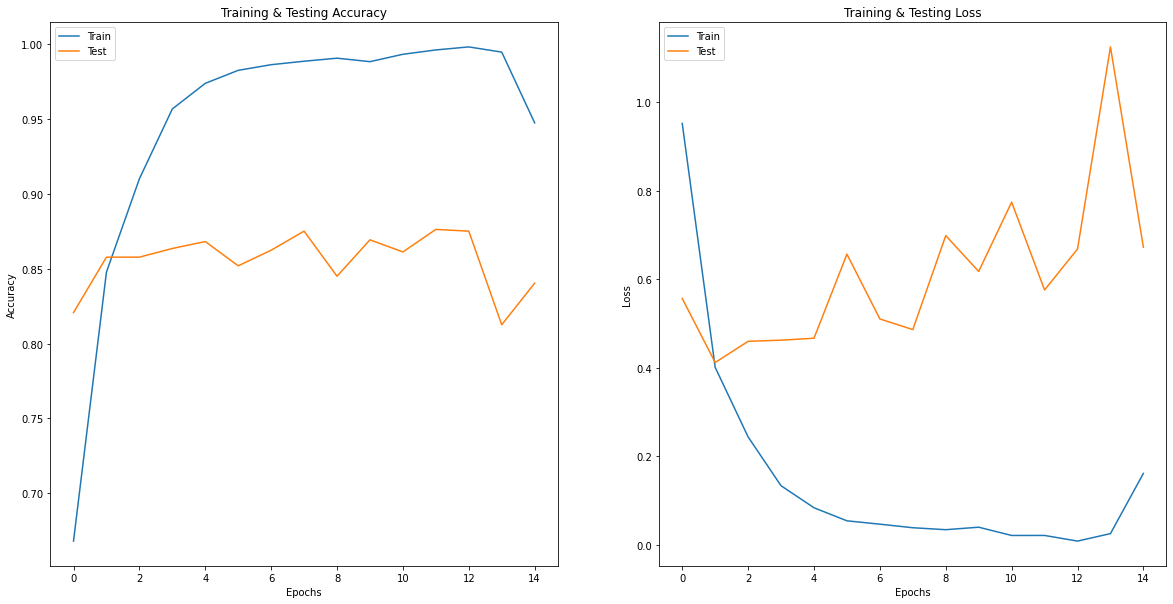

In [23]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training & Testing Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training & Testing Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Train', 'Test'], loc='upper left')

plt.show()

In [24]:
predictions = model.predict_classes(x_test)
predictions[:5]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([2, 1, 0, 1, 4])

In [25]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [26]:
print(classification_report(y_test_inv, predictions, target_names = labels))

              precision    recall  f1-score   support

   dandelion       0.83      0.94      0.88       210
       daisy       0.84      0.84      0.84       153
       tulip       0.79      0.84      0.81       197
   sunflower       0.89      0.83      0.86       147
        rose       0.89      0.71      0.79       157

    accuracy                           0.84       864
   macro avg       0.85      0.83      0.84       864
weighted avg       0.84      0.84      0.84       864



<AxesSubplot:>

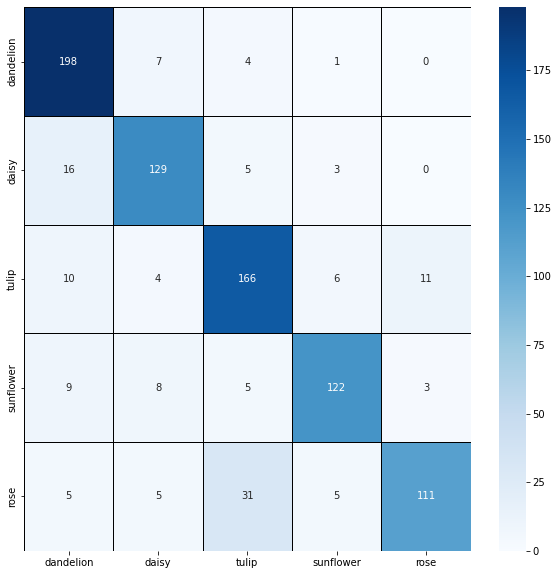

In [27]:
cm = confusion_matrix(y_test_inv,predictions)
cm = pd.DataFrame(cm , index = labels , columns = labels)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)

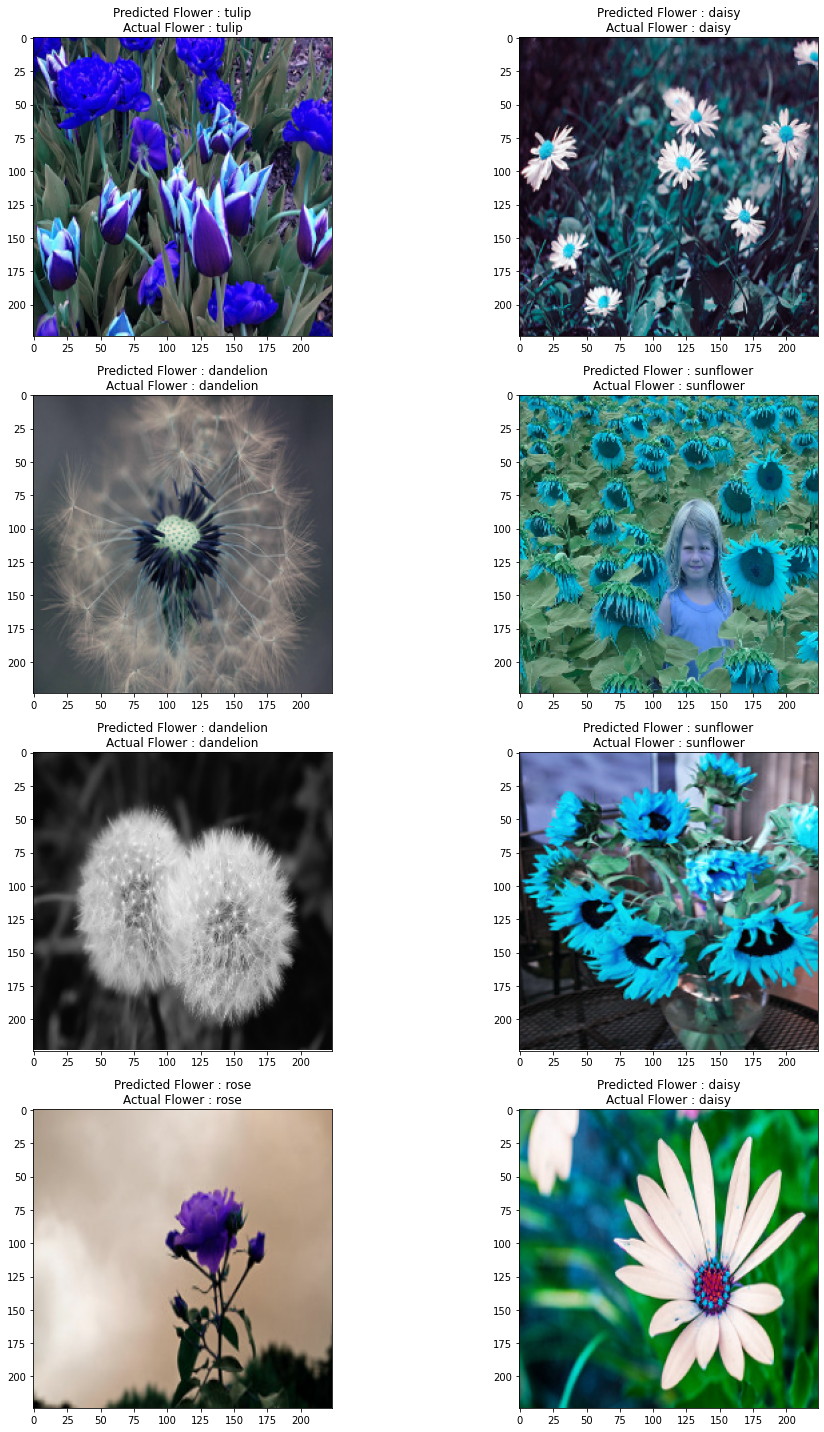

In [34]:
import random

fig,ax=plt.subplots(4,2)
fig.set_size_inches(20,20)

for i in range (4):
    for j in range (2):
        number = random.randint(0, x_test.shape[0])
        ax[i,j].imshow(x_test[number])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[number]] +"\n"+"Actual Flower : "+ labels[y_test_inv[number]])
        plt.tight_layout()
